# Volumetric analyses
ref: [link](https://userguide.mdanalysis.org/stable/examples/analysis/volumetric/README.html)


In [1]:
import warnings

import MDAnalysis as mda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from MDAnalysis.tests.datafiles import waterPSF, waterDCD
from MDAnalysis.analysis import lineardensity as lin

warnings.filterwarnings('ignore')
%matplotlib inline

## Computing mass and charge density on each axis
Here we compute the mass and charge density of water along the three cartesian axes of a fixed-volume unit cell (i.e. from a simulation in the NVT ensemble).

`MDAnalysis.analysis.lineardensity.LinearDensity` will partition each of your axes into bins of user-specified `binsize` (in angstrom), and give the average mass density and average charge density of your atom group selection.

This analysis is only suitable for a trajectory with a fixed box size. While passing a trajectory with a variable box size will not raise an error, `LinearDensity` will not account for changing dimensions. It will only evaluate the density of your atoms in the bins created from the trajectory frame when the class is first initialised.

Below, we iterate through the trajectory to verify that its box dimensions remain constant.

In [2]:
# loading files
u = mda.Universe(waterPSF, waterDCD)

In [3]:
for ts in u.trajectory:
    print(ts.dimensions)

[50. 50. 50. 90. 90. 90.]
[50. 50. 50. 90. 90. 90.]
[50. 50. 50. 90. 90. 90.]
[50. 50. 50. 90. 90. 90.]
[50. 50. 50. 90. 90. 90.]
[50. 50. 50. 90. 90. 90.]
[50. 50. 50. 90. 90. 90.]
[50. 50. 50. 90. 90. 90.]
[50. 50. 50. 90. 90. 90.]
[50. 50. 50. 90. 90. 90.]


You can choose to compute the density of individual atoms, residues, segments, or fragments (groups of bonded atoms with no bonds to any atom outside the group). By default, the grouping is for `atoms`.

In [4]:
density_ana = lin.LinearDensity(u.atoms,
                            grouping='atoms').run()

In [5]:
density_ana.nbins

200

In [6]:
density_ana.results['x']['mass_density']

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00053562, 0.00080344, 0.00876945, 0.03507781, 0.00107125,
       0.00348155, 0.00241031, 0.02791523, 0.04277601, 0.01753

In [7]:
density_ana.results['x'].keys()

KeysView({'dim': 0, 'slice_volume': 625.0, 'mass_density': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00053562, 0.00080344, 0.00876945, 0.03507781, 0.00107125,
   

In [8]:
density_ana.results['y']['dim']

1

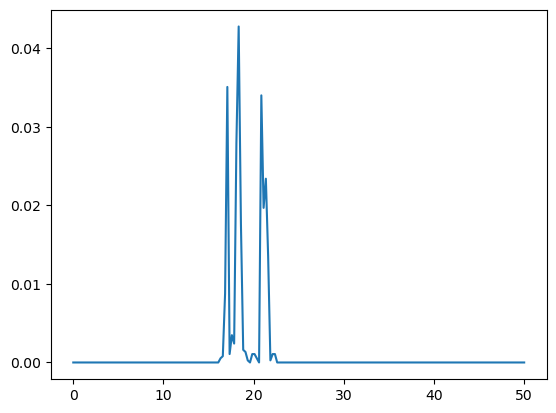

In [12]:
plt.plot(np.linspace(0, 50, 200), density_ana.results['x']['mass_density'])

## Calculating the solvent density around a protein

In [13]:
import nglview as nv

from MDAnalysis.tests.datafiles import TPR, XTC

In [14]:
# loading files
u = mda.Universe(TPR, XTC)

# ngl view
view1 = nv.show_mdanalysis(u)
view1.add_representation(
    'licorice',
    selection='resname SOL',
)
view1

NGLWidget(max_frame=9)

In [15]:
# Centering, aligning, and making molecules whole with on-the-fly transformations

from MDAnalysis import transformations as trans
from MDAnalysis.analysis import density

protein = u.select_atoms('protein')
water = u.select_atoms('resname SOL')

workflow = [trans.unwrap(u.atoms),  # unwrap all fragments
            trans.center_in_box(protein, # move atoms so protein
                                center='geometry'), # is centered
            trans.wrap(water, # wrap water back into box
                       compound='residues'), # keep each water whole
            trans.fit_rot_trans(protein, # align protein to first frame
                                protein,
                                weights='mass'),
           ]

u.trajectory.add_transformations(*workflow)

In [16]:
view2 = nv.show_mdanalysis(u)
view2.add_representation(
    'licorice',
    selection='resname SOL',
)
view2

NGLWidget(max_frame=9)

In [17]:
# Analysing the density of water around the protein
ow = u.select_atoms('name OW')
dens = density.DensityAnalysis(ow,
                               delta=4.0,
                               padding=2)
dens.run()

In [18]:
grid = dens.results.density.grid
grid.shape


(31, 42, 20)

In [19]:
dens.results.density.units

{'length': 'Angstrom', 'density': 'Angstrom^{-3}'}

In [20]:
dens.results.density.convert_density('TIP4P')
dens.results.density.units

{'length': 'Angstrom', 'density': 'TIP4P'}

In [21]:
# visualizing the density
mx, my, mz = dens.results.density.midpoints

# we need to first normalise the density values. 
# In the flat vector below before, the highest opacity 
# (i.e. the point with the highest density of water oxygen atoms) is 0.1. 
# The array is also flattened so we can treat it as a list of values.
grid = dens.results.density.grid
flat = grid.ravel() / (grid.max()*10)


# We set the colour to an RGBA array representing the colour blue. 
# The last number in an RGBA array represents the alpha channel, 
# which controls the opacity of the point.
blue = [44, 130, 201, 1]
colors = [blue] * len(mx) * len(my) * len(mz)
colors = np.array(colors, dtype=float)
colors[:, -1] *= flat
colors[:, :3] /= 255


### Plotting

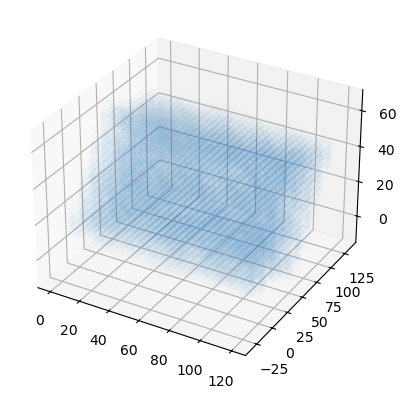

In [22]:
# matplotlib (3D static plot)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = np.meshgrid(mx, my, mz)

ax.scatter(x, y, z, c=colors)
plt.show()

In [23]:
# nglview (interactive)

dens.results.density.export("water.dx")

view3 = nv.show_mdanalysis(u)
d = view3.add_component("water.dx")
d.clear_representations()
d.add_surface(isolevel=0.5, isolevel_type="value", opacity=0.1, contour=False, smooth=1, color="blue")
d.add_surface(isolevel=1.2, isolevel_type="value", opacity=1, contour=True, smooth=1, color="cyan")

view3

NGLWidget(max_frame=9)

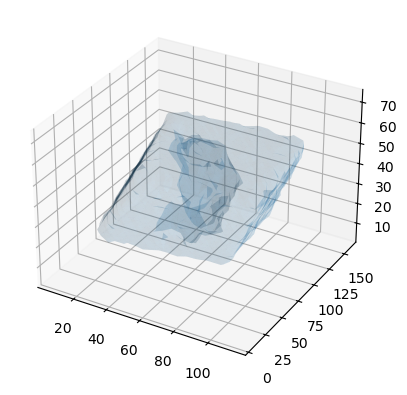

In [25]:
# scikit-image (triangulated surface)

from skimage import measure
from mpl_toolkits.mplot3d import Axes3D

iso_val = 0.5
verts, faces, _, _ = measure.marching_cubes(dens.results.density.grid, iso_val,
                                                    spacing=dens.results.density.delta)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                lw=1, alpha=0.1)
plt.show()

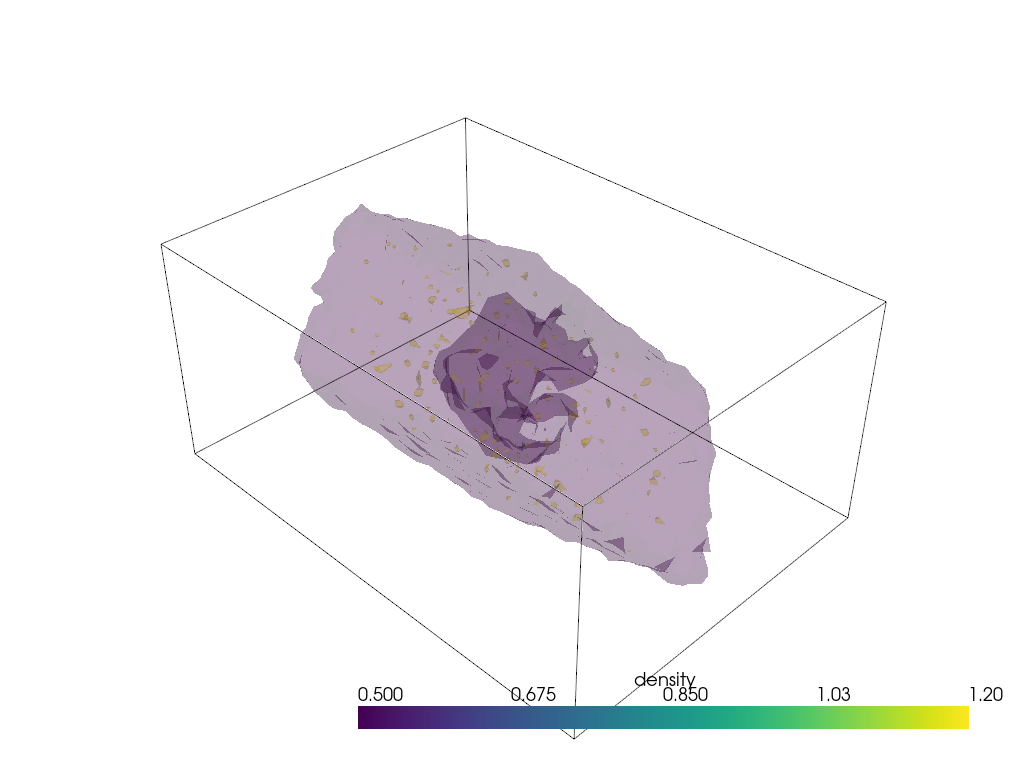

In [26]:
# pyvista (3D surface)
import pyvista as pv

pv.set_plot_theme("document")

x, y, z = np.meshgrid(mx, my, mz, indexing="ij")
mesh = pv.StructuredGrid(x, y, z)
mesh["density"] = dens.results.density.grid.T.flatten() # note transpose
contours = mesh.contour([0.5, 1.2])

p = pv.Plotter(notebook=True)
p.background_color = 'white'
p.add_mesh(mesh.outline(), color="k")  # box lines
p.add_mesh(contours, opacity=0.2);  # surfaces

# uncomment the below for interactivity
p.show()
# p.screenshot("./density_analysis_images/surface.png");

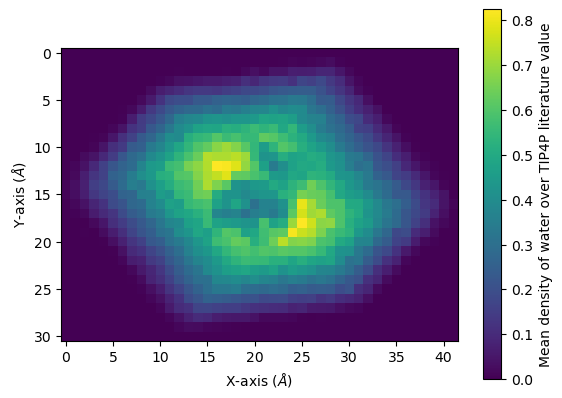

In [27]:
# 2D averaging

avg = grid.mean(axis=-1)
avg.shape

fig, ax = plt.subplots()

im = ax.imshow(avg)
cbar = plt.colorbar(im)
cbar.set_label('Mean density of water over TIP4P literature value')
plt.xlabel('X-axis ($\AA$)')
plt.ylabel('Y-axis ($\AA$)')
plt.show()

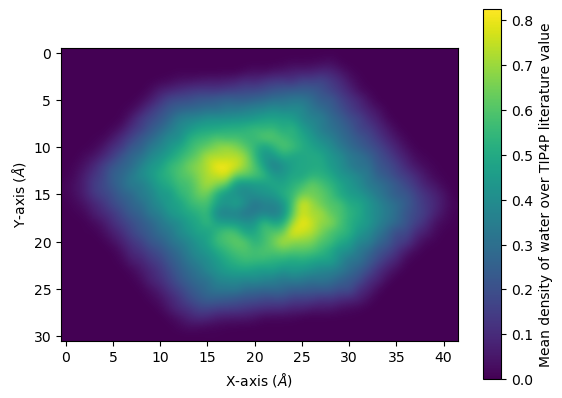

In [28]:
fig, ax = plt.subplots()

im = ax.imshow(avg, interpolation="bicubic")
cbar = plt.colorbar(im)
cbar.set_label('Mean density of water over TIP4P literature value')
plt.xlabel('X-axis ($\AA$)')
plt.ylabel('Y-axis ($\AA$)')
plt.show()
